In [1]:
import xymass
import numpy as np
import scipy
import astropy.units as u
%matplotlib inline
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#define sample size (number of binary systems)

n_object=10000

#sample mass function for primaries, need to specify units via astropy.units
mass_primary=xymass.sample_imf(size=n_object,model='kroupa').mass*u.M_sun 

#sample m_secondary / m_primary from uniform distribution
mass_ratio=np.random.uniform(size=n_object,low=0.,high=1.) 

#sample (truncated) log-normal period distribution, need to specify units via astropy.units
period=10.**xymass.sample_normal_truncated(size=n_object,loc=1.,scale=1.,min_value=-np.inf,max_value=np.inf)*u.yr 

#sample (truncated) log-normal eccentricity distribution
eccentricity=10.**xymass.sample_normal_truncated(size=n_object,loc=-0.3,scale=1.,min_value=-np.inf,max_value=0.) 

#sample time of observation, as a fraction of the orbital period (sampling uniform distribution here)
f_period=np.random.uniform(size=n_object,low=0.,high=1.) 

#sample inclination angle (need to specify units via astropy.units)
#inclination=0 for observer along +z axis, inclination=pi/2 for observer in xy plane
#allowed from 0 to 2*pi to allow for full range of parity.
inclination=xymass.sample_inclination(size=n_object)*u.rad 

#sample longitude of ascending node, need to specify units via astropy.units
#longitude=0 if observer is along +x axis, longitude=pi/2 if observer is along +y axis
longitude=np.random.uniform(size=n_object,low=0,high=2.*np.pi)*u.rad  

In [3]:
#calculate orbital elements for each system
orbit_snapshot=xymass.sample_orbit_2body(f_period,period=period,eccentricity=eccentricity,\
                                         mass_primary=mass_primary,mass_ratio=mass_ratio,\
                                         longitude=longitude,inclination=inclination)


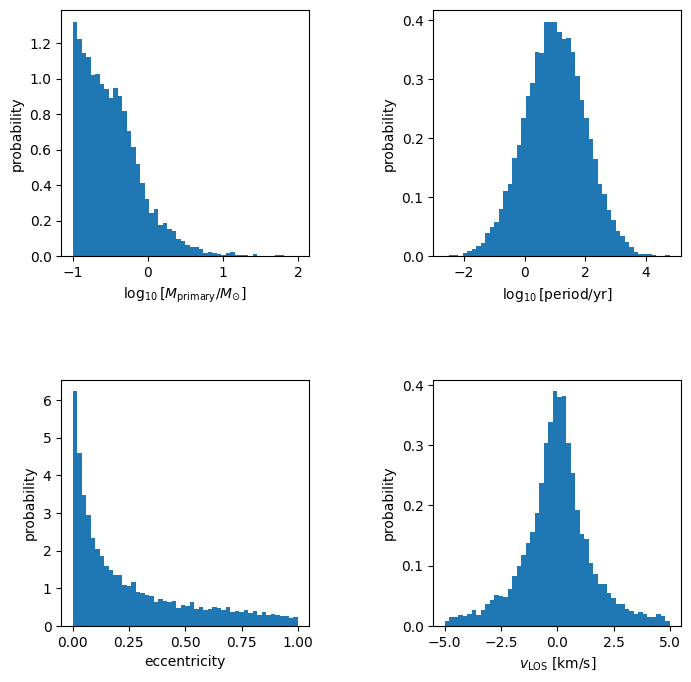

In [4]:
fig=plt.figure(figsize=(8,8))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)
fig.subplots_adjust(wspace=0.5,hspace=0.5)
ax1.hist(np.log10(mass_primary.value),bins=50,density=True)
ax2.hist(np.log10(period.value),bins=50,density=True)
ax3.hist(eccentricity,bins=50,density=True)
ax4.hist(orbit_snapshot.v_obs_xyz.T[2].value,bins=50,density=True,range=[-5,5])
ax1.set_xlabel(r'$\log_{10}[M_{\rm primary}/M_{\odot}]$')
ax2.set_xlabel(r'$\log_{10}[\mathrm{period/yr}]$')
ax3.set_xlabel('eccentricity')
ax4.set_xlabel(r'$v_{\rm LOS}$ [km/s]')
for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylabel('probability')
plt.show()

In [5]:
#define parameters of a single orbit
period=1.*u.yr
eccentricity=0.6
mass_primary=1.*u.M_sun
mass_ratio=0.2 #M_secondary/M_primary
longitude=15.*np.pi/180.*u.rad #longitude of ascending node
inclination=81.*np.pi/180.*u.rad #inclination angle

#sample f_period = time / period uniformly over one full period
f_period=np.linspace(0,1,200)

In [6]:
#calculate orbit
sample_orbit=xymass.sample_orbit_2body(f_period,period=period,eccentricity=eccentricity,\
                                       mass_primary=mass_primary,mass_ratio=mass_ratio,\
                                       longitude=longitude,inclination=inclination)

In [7]:
#animate positions of reduced mass, particle 1 and particle 2

#first, change backend to support animation
%matplotlib tk 
%matplotlib tk
import matplotlib.pyplot as plt

xymass.animation_2body_r(sample_orbit,animation_filename=None)

In [8]:
#animate velocities of reduced mass, particle 1 and particle 2

xymass.animation_2body_v(sample_orbit,animation_filename=None)

In [9]:
from xymass import get_solar_spec
def get_spectrum(wav,flux):
    class spectrum:
        def __init__(self,wav=None,flux=None):
            self.wav=wav
            self.flux=flux
    return spectrum(wav=wav,flux=flux)

solar_spec=xymass.get_solar_spec.get_spec_array()
wav,sun=solar_spec.T[0],solar_spec.T[1]

npix=10000
gaussian_filter_scale=0.1
flux=np.zeros((len(sample_orbit.r_xyz),npix))
flux1=np.zeros((len(sample_orbit.r_xyz),npix))
flux2=np.zeros((len(sample_orbit.r_xyz),npix))
wav_interp=np.linspace(5100,5200,npix)
for i in range(0,len(sample_orbit.r_xyz)):
    wav1=wav*(1.+sample_orbit.v1_obs_xyz.T[2][i].to(u.km/u.s).value/3.0e+5)
    wav2=wav*(1.+sample_orbit.v2_obs_xyz.T[2][i].to(u.km/u.s).value/3.0e+5)
    flux1_0=np.interp(wav_interp,wav1,sun)
    flux2_0=np.interp(wav_interp,wav2,sun)
    flux_0=flux1_0+flux2_0
    flux[i]=scipy.ndimage.gaussian_filter(flux_0/np.max(flux_0),sigma=gaussian_filter_scale)
    flux1[i]=scipy.ndimage.gaussian_filter(flux1_0/np.max(flux1_0),sigma=gaussian_filter_scale)
    flux2[i]=scipy.ndimage.gaussian_filter(flux2_0/np.max(flux2_0),sigma=gaussian_filter_scale)
spec1=get_spectrum(wav=wav_interp,flux=flux1)
spec2=get_spectrum(wav=wav_interp,flux=flux2)
spec=get_spectrum(wav=wav_interp,flux=flux)
#spectrum=np.random
xymass.animation_2body_spec(sample_orbit,spec,spec1,spec2,animation_filename=None)
